# Preparation

## Imports

In [37]:
# Data handling
import pandas as pd
import numpy as np
# Plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
# Statistical analyses
import itertools
from scipy.stats import norm, truncnorm, gaussian_kde
from scipy.stats import ks_2samp, pearsonr
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statistics import NormalDist
# IO
import sys

## Paths

In [2]:
# Base path for functions
base_path = "C:/repos/"
sys.path.append(base_path)

# Path to find run results
results_path = base_path + "twrds_unbiased_anns/runs/results/"

# Path to store figures
figure_path = base_path + "twrds_unbiased_anns/figures/results/"

## Functions

In [3]:
# Data
from twrds_unbiased_anns.src.analysis.data import load_run_data
# Plotting

# Analysis

## Parameters

In [85]:
# Run specific
run_name = "stddev_and_meandiff_color"
run_date = "19-03-2021"
predictors = ["m_diff", "stddev", "overlap"]
predictor_xlims = [(0,60), (0,30), (0,1)]
# General
color_over = "lightgrey"
color_under = "lightcoral"
targets = ["prediction", "rmse"]
target_labels = ["Prediction", "RMSE"]
target_ylims = [(65,85), (0,10)]

## Data Loading

In [5]:
df = load_run_data(run_name, run_date, results_path)
# Calculate overlap
df["overlap"] = df.apply(lambda row: get_overlap(row), axis=1)
# Add log columns for predictors
for predictor in predictors:
    df["log_" + predictor] = np.log(df[predictor])
# Remove infinte log values
df = df.replace([np.inf, -np.inf], np.nan)
# Create groups for over- and underestimated means in training sample
df_over = df[df.group == "over"]
df_under = df[df.group == "under"]

In [76]:
df_over = df[df.group == "over"]
df_under = df[df.group == "under"]

In [57]:
df = df.replace([np.inf, -np.inf], np.nan)
df

,Unnamed: 0,run,date,model,loss,category,m_diff,stddev,minority_share,repeat,...,shape_type,actual,prediction,group,prediction_diff,rmse,overlap,log_m_diff,log_stddev,log_overlap
0,0,stddev_and_meandiff_color,2021-03-18 17:38:38.227,SimpleCNN,mse,color,0,3,50,1,...,square,116,110.739868,over,-5.260132,5.260132,1.000000,NaN,1.098612,0.000000
1,1,stddev_and_meandiff_color,2021-03-18 17:38:38.227,SimpleCNN,mse,color,0,3,50,1,...,square,55,55.076237,over,0.076237,0.076237,1.000000,NaN,1.098612,0.000000
2,2,stddev_and_meandiff_color,2021-03-18 17:38:38.227,SimpleCNN,mse,color,0,3,50,1,...,square,46,41.866882,over,-4.133118,4.133118,1.000000,NaN,1.098612,0.000000
3,3,stddev_and_meandiff_color,2021-03-18 17:38:38.227,SimpleCNN,mse,color,0,3,50,1,...,square,53,51.931202,over,-1.068798,1.068798,1.000000,NaN,1.098612,0.000000
4,4,stddev_and_meandiff_color,2021-03-18 17:38:38.227,SimpleCNN,mse,color,0,3,50,1,...,square,99,96.597641,over,-2.402359,2.402359,1.000000,NaN,1.098612,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269995,269995,stddev_and_meandiff_color,2021-03-18 17:38:38.227,SimpleCNN,mse,color,60,30,50,5,...,circle,41,40.706104,under,-0.293896,0.293896,0.317311,4.094345,3.401197,-1.147874
269996,269996,stddev_and_meandiff_color,2021-03-18 17:38:38.227,SimpleCNN,mse,color,60,30,50,5,...,circle,98,98.389847,under,0.389847,0.389847,0.317311,4.094345,3.401197,-1.147874
269997,269997,stddev_and_meandiff_color,2021-03-18 17:38:38.227,SimpleCNN,mse,color,60,30,50,5,...,circle,79,78.816261,under,-0.183739,0.183739,0.317311,4.094345,3.401197,-1.147874
269998,269998,stddev_and_meandiff_color,2021-03-18 17:38:38.227,SimpleCNN,mse,color,60,30,50,5,...,circle,87,87.147308,under,0.147308,0.147308,0.317311,4.094345,3.401197,-1.147874


In [58]:
df.log_m_diff.min()

1.6094379124341003

## Predictions

### Individual Plots

In [62]:
def plot_means(df, predictor, target, color, ax):    
    # Get 95% confidence intervals of means
    stats = df.groupby([predictor])[target].agg(['mean', 'count', 'std'])
    ci95_hi = []
    ci95_lo = []
    for i in stats.index:
      m, c, s = stats.loc[i]
      ci95_hi.append(m + 1.95*s/np.sqrt(c))
      ci95_lo.append(m - 1.95*s/np.sqrt(c))
    stats['ci95_hi'] = ci95_hi
    stats['ci95_lo'] = ci95_lo
    stats['grp'] = stats.index
    # Plot confidence intervals
    for grp in stats.index:
        ax.vlines(x=grp, ymin=stats.loc[grp]['ci95_lo'], ymax=stats.loc[grp]['ci95_hi'], color = color)
    # Plot means
    ax.scatter(x=stats['grp'], y=stats['mean'], s = 10, color = color)
    
def plot_ols(df, predictor, target, color, ax, line_x):
    # Plot group means
    plot_means(df, predictor, target, color, ax)
    # Fit OLS to each data group
    model = ols('{} ~ {}'.format(target, predictor), df).fit()
    # Plot OLS lines
    p = model.params
    line_y = p.Intercept + p[1] * line_x
    ax.plot(line_x, line_y, color = color)
    return line_y

def get_overlap(row):
    dist_1 = NormalDist(mu=75+row.m_diff/2, sigma=row.stddev)
    dist_2 = NormalDist(mu=75-row.m_diff/2, sigma=row.stddev)
    return dist_1.overlap(dist_2)

In [44]:
df["overlap"] = df.apply(lambda row: get_overlap(row), axis=1)

Predictor: m_diff, Target: prediction


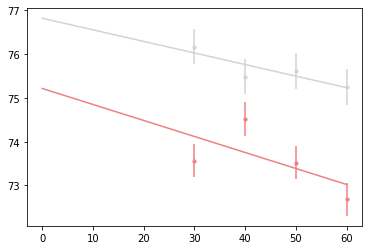

<ipython-input-74-55549c003b44>:22: RuntimeWarning: divide by zero encountered in log
  line_x = np.log(np.arange(xmin, xmax, step = 0.001))


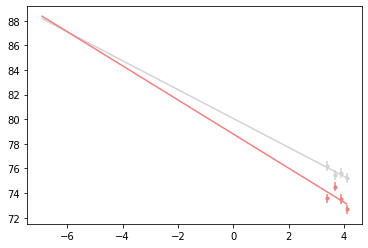

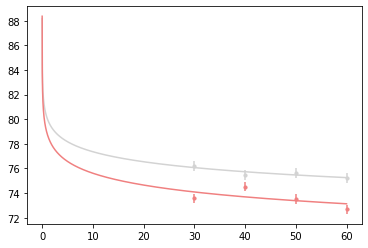

Predictor: m_diff, Target: rmse


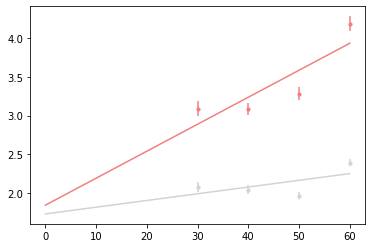

<ipython-input-74-55549c003b44>:22: RuntimeWarning: divide by zero encountered in log
  line_x = np.log(np.arange(xmin, xmax, step = 0.001))


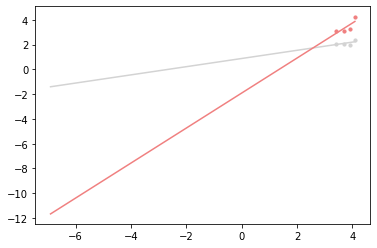

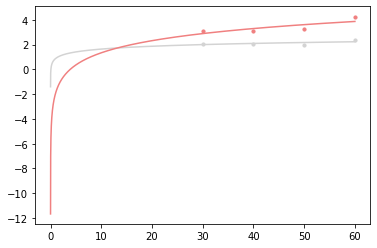

Predictor: stddev, Target: prediction


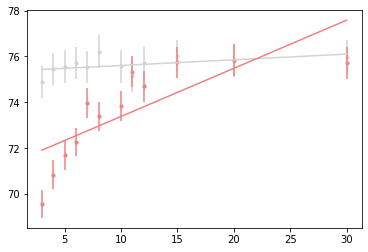

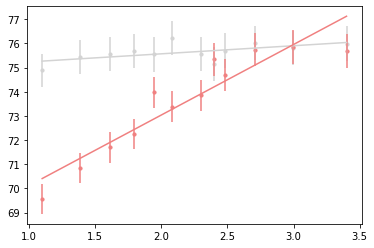

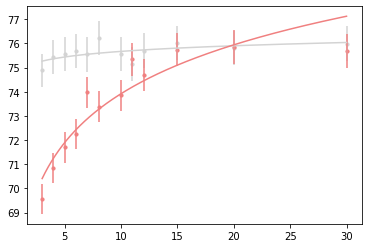

Predictor: stddev, Target: rmse


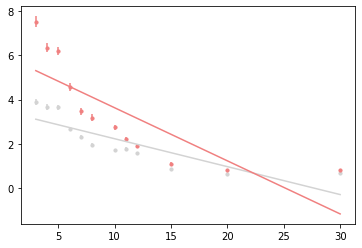

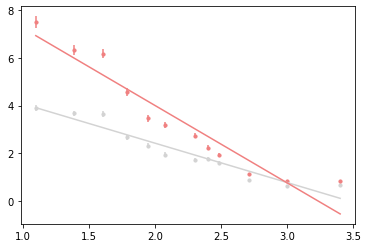

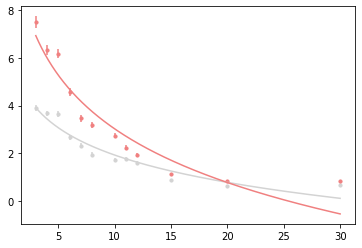

Predictor: overlap, Target: prediction


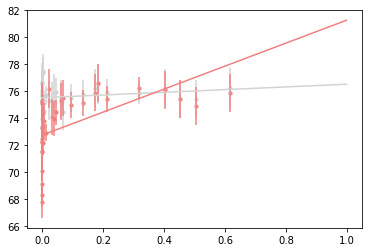

<ipython-input-74-55549c003b44>:22: RuntimeWarning: divide by zero encountered in log
  line_x = np.log(np.arange(xmin, xmax, step = 0.001))


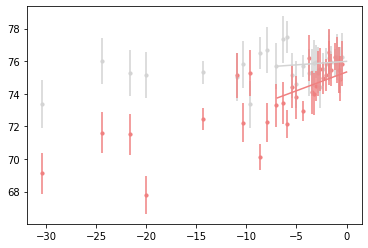

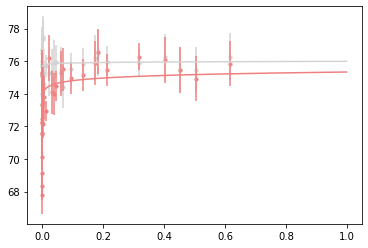

Predictor: overlap, Target: rmse


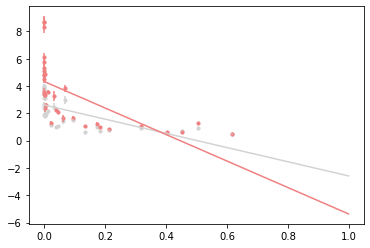

<ipython-input-74-55549c003b44>:22: RuntimeWarning: divide by zero encountered in log
  line_x = np.log(np.arange(xmin, xmax, step = 0.001))


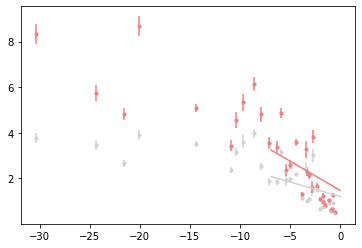

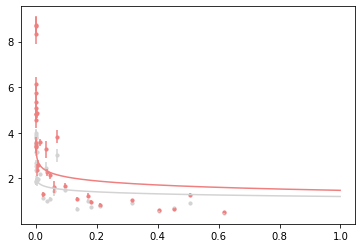

In [74]:
for predictor in predictors:
    for target in targets:
        # Print combination
        print("Predictor: {}, Target: {}".format(predictor, target))
        # Create plotting area
        fig = plt.plot(figsize=(10,3.75))
        ax = plt.gca()
        # Plot OLS for each group
        xmin, xmax = df[predictor].min(), df[predictor].max()
        line_x = np.arange(xmin, xmax, step = 0.001)
        plot_ols(df_over, predictor, target, color_over, ax, line_x)
        plot_ols(df_under, predictor, target, color_under, ax, line_x)
        # Show plot
        plt.show()
        
        # Log scale
        log_predictor = "log_" + predictor
        # Create plotting area
        fig = plt.plot(figsize=(10,3.75))
        ax = plt.gca()
        # Plot OLS for each group
        line_x = np.log(np.arange(xmin, xmax, step = 0.001))
        y_over = plot_ols(df_over, log_predictor, target, color_over, ax, line_x)
        y_under = plot_ols(df_under, log_predictor, target, color_under, ax, line_x)
        # Show plot
        plt.show()
        
        # Log scale transformed back to normal scale
        # Create plotting area
        fig = plt.plot(figsize=(10,3.75))
        ax = plt.gca()
        # Plot OLS for each group
        plot_means(df_over, predictor, target, color_over, ax)
        plot_means(df_under, predictor, target, color_under, ax)
        line_x = np.arange(xmin, xmax, step = 0.001)
        ax.plot(line_x, y_over, color = color_over)
        ax.plot(line_x, y_under, color = color_under)
        # Show plot
        plt.show()

0


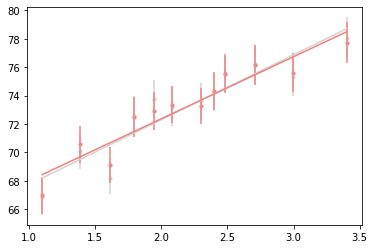

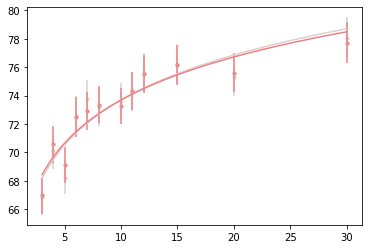

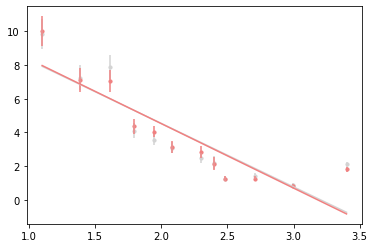

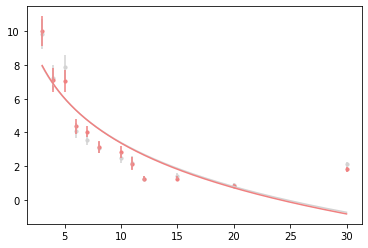

5


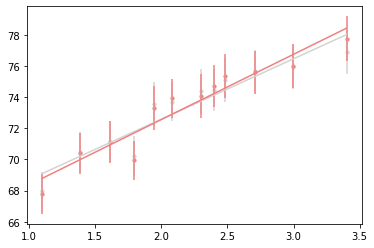

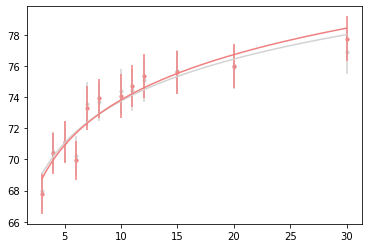

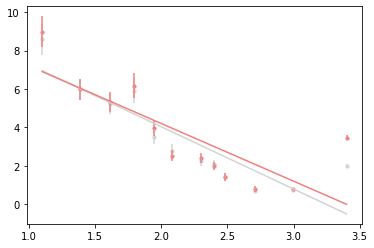

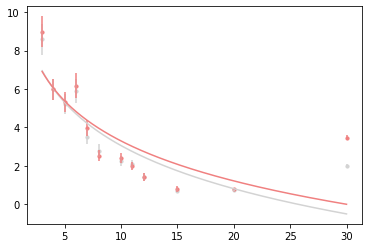

10


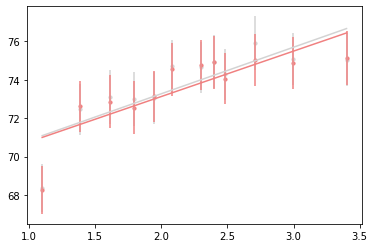

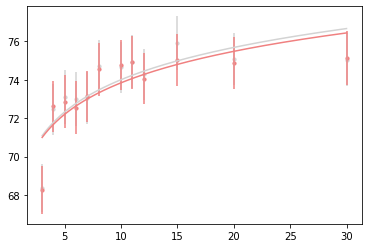

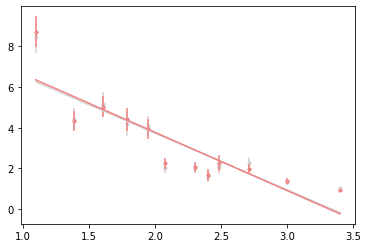

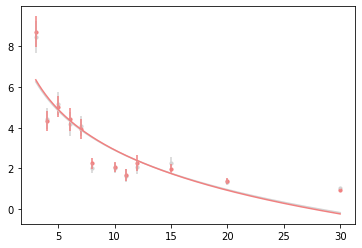

15


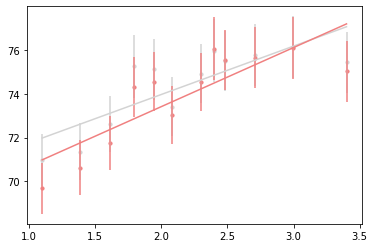

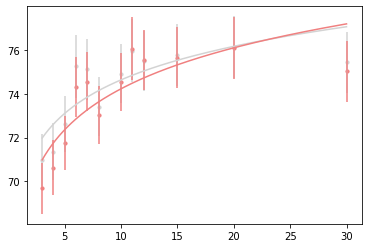

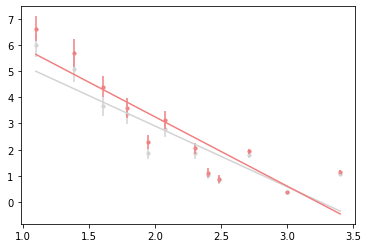

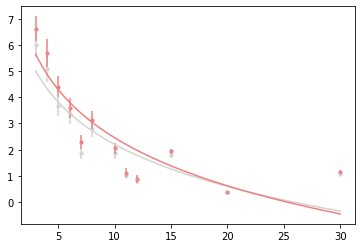

20


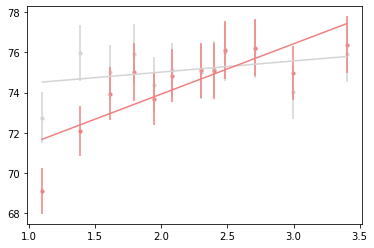

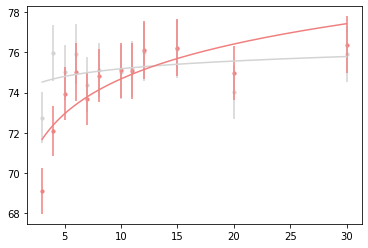

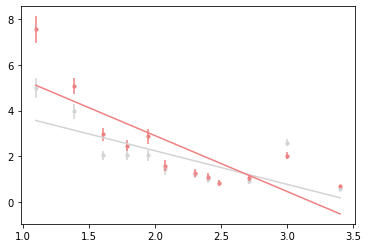

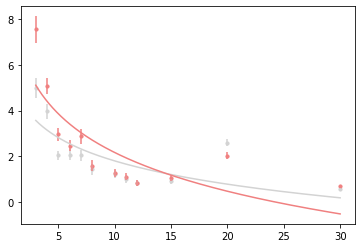

30


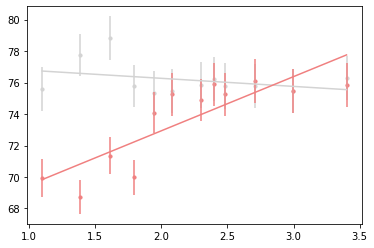

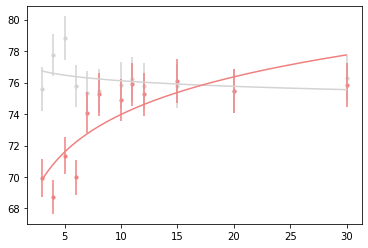

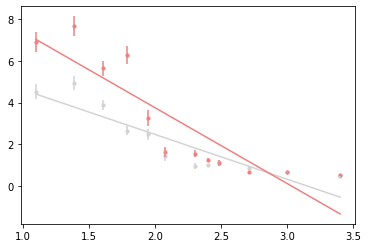

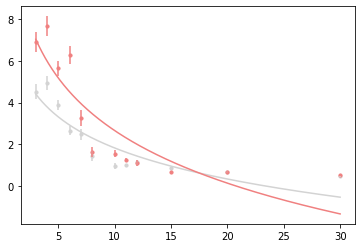

40


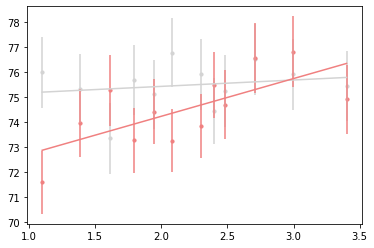

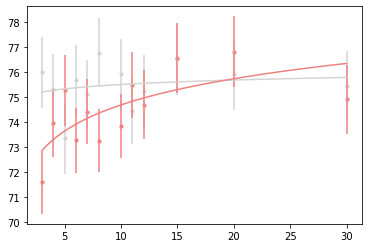

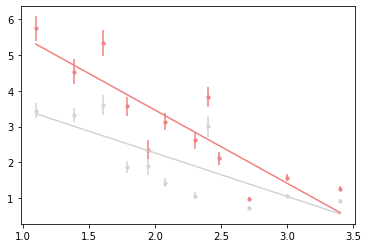

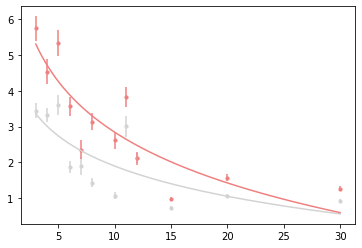

50


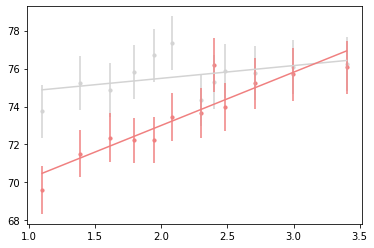

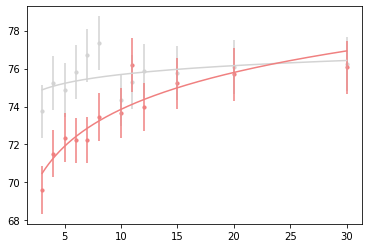

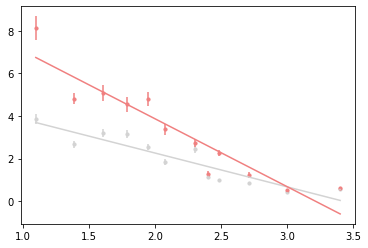

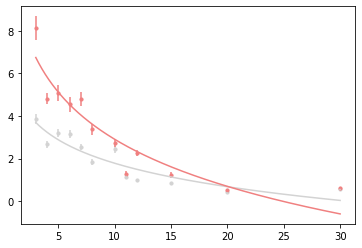

60


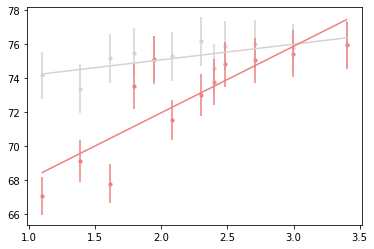

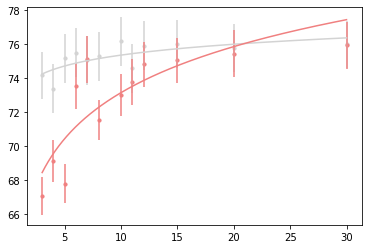

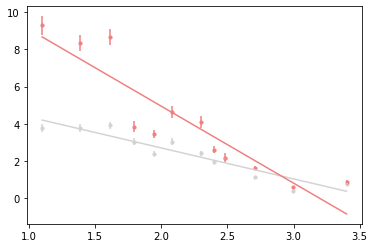

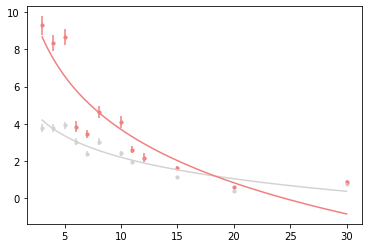

In [84]:
# TODO stddev curve by meandiff
predictor = "stddev"
grouped_over = df_over.groupby(df.m_diff)
grouped_under = df_under.groupby(df.m_diff)
for group in grouped_over.groups.keys():
    print(group)
    for target in targets:
        data_over = grouped_over.get_group(group)
        data_under = grouped_under.get_group(group)
        
        xmin, xmax = df[predictor].min(), df[predictor].max()
        # Log scale
        log_predictor = "log_" + predictor
        # Create plotting area
        fig = plt.plot(figsize=(10,3.75))
        ax = plt.gca()
        # Plot OLS for each group
        line_x = np.log(np.arange(xmin, xmax, step = 0.001))
        y_over = plot_ols(data_over, log_predictor, target, color_over, ax, line_x)
        y_under = plot_ols(data_under, log_predictor, target, color_under, ax, line_x)
        # Show plot
        plt.show()

        # Log scale transformed back to normal scale
        # Create plotting area
        fig = plt.plot(figsize=(10,3.75))
        ax = plt.gca()
        # Plot OLS for each group
        plot_means(data_over, predictor, target, color_over, ax)
        plot_means(data_under, predictor, target, color_under, ax)
        line_x = np.arange(xmin, xmax, step = 0.001)
        ax.plot(line_x, y_over, color = color_over)
        ax.plot(line_x, y_under, color = color_under)
        # Show plot
        plt.show()

In [10]:
model = ols('prediction ~ {}'.format(predictor, df_over).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             prediction   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     168.0
Date:                Fri, 19 Mar 2021   Prob (F-statistic):           2.17e-38
Time:                        18:51:15   Log-Likelihood:            -6.2679e+05
No. Observations:              135000   AIC:                         1.254e+06
Df Residuals:                  134998   BIC:                         1.254e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     73.3782      0.122    602.601      0.0

In [12]:
model.params

Intercept    73.378161
stddev        0.119609
dtype: float64

## Predictions

## Predictions

### General OLS

In [66]:
model = ols('prediction ~ m_diff + log_stddev + group + overlap + overlap * group + log_stddev * group + m_diff * group + log_stddev * m_diff + log_stddev * m_diff * group', df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             prediction   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     187.7
Date:                Sat, 20 Mar 2021   Prob (F-statistic):               0.00
Time:                        09:58:21   Log-Likelihood:            -1.2481e+06
No. Observations:              270000   AIC:                         2.496e+06
Df Residuals:                  269990   BIC:                         2.496e+06
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

In [67]:
model = ols('rmse ~ m_diff + log_stddev + group + overlap + overlap * group + log_stddev * group + m_diff * group + log_stddev * m_diff + log_stddev * m_diff * group', df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   rmse   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     3071.
Date:                Sat, 20 Mar 2021   Prob (F-statistic):               0.00
Time:                        11:13:43   Log-Likelihood:            -8.6269e+05
No. Observations:              270000   AIC:                         1.725e+06
Df Residuals:                  269990   BIC:                         1.725e+06
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep